In [41]:
import etl_eda
import importlib
importlib.reload(etl_eda)
from etl_eda import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, normaltest, spearmanr
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
df_train = load('train.csv')
df_item_categories = load('item_categories.csv')
df_shops = load('shops.csv')
df_items  = load('items.csv')

In [52]:
df_train[['item_cnt_month', 'item_price']].describe().map(lambda x: f"{x:0.1f}")

,item_cnt_month,item_price
count,42474228.0,42474228.0
mean,0.1,30.0
std,1.7,334.3
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,1644.0,50999.0


ITEM_CNT_MONTH

In [4]:
df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'].count()

np.int64(915)

Item_cnt_month must be positive

In [5]:
df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'] = np.multiply(df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'],(-1))

Item_cnt_month destribution

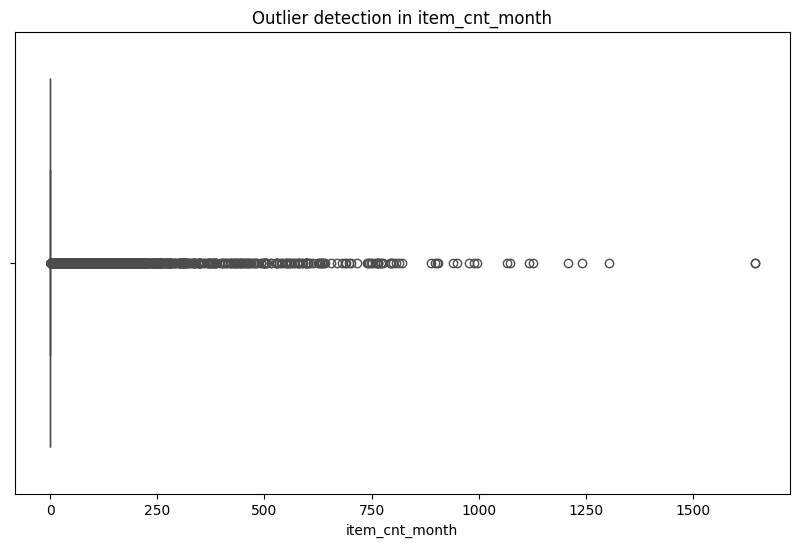

In [18]:
boxplot(df_train, 'item_cnt_month')

Distribution of 'Item_cnt_month' is skewed

Outliers specification

In [46]:
outliers = df_train[df_train.item_cnt_month > 850]

In [47]:
outliers.item_cnt_month.describe().map('{:,.2f}'.format)

count       18.00
mean     1,104.28
std        232.21
min        888.00
25%        943.25
50%      1,031.50
75%      1,188.50
max      1,644.00
Name: item_cnt_month, dtype: object

check of 3 random outliers

In [61]:
check = outliers.sample(n = 3)
outliers_spec(check, 'item_cnt_month', df_item_categories, df_items)

Категория: Игровые консоли - XBOX ONE
Комплект "Microsoft Xbox One 500GB" + "Xbox One Kinect (Сенсор)" + "Dance Central Spotlight" + "Xbox
          date_block_num  item_cnt_month
31849917              25             1.0
Категория: Программы - 1С:Предприятие 8
1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для розничного распространения (USB)
          date_block_num  item_cnt_month
28784382              23             1.0
Категория: Программы - Для дома и офиса
CorelDRAW Graphics Suite X6 - Small Business Edition Russian BOX
          date_block_num  item_cnt_month
10142148               8             1.0


Data that looked like outliers correspond to real-world data

Log transformation of 'item_cnt_month' to reduce skewness 

In [50]:
df_train['item_cnt_month_log'] = np.log1p(df_train['item_cnt_month'])

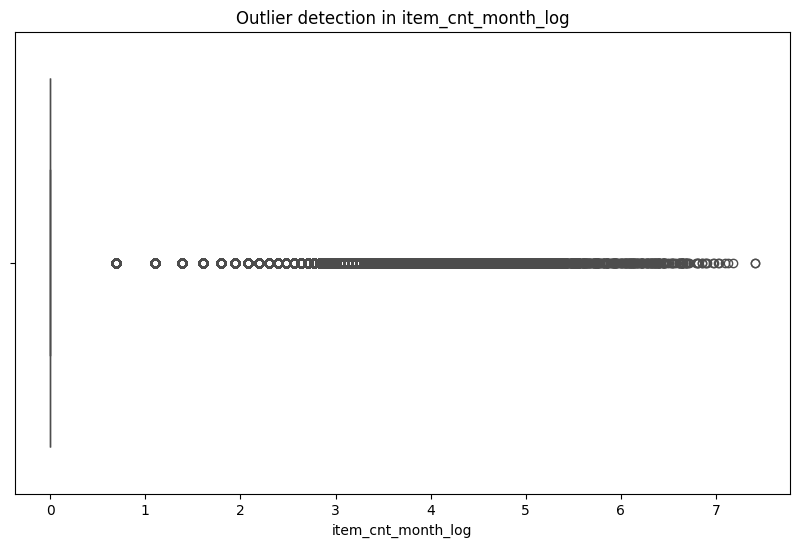

In [51]:
boxplot(df_train, 'item_cnt_month_log')

In [54]:
df_train.item_cnt_month_log.describe().map(lambda x: f"{x:0.3f}")

count    42474228.000
mean            0.036
std             0.206
min             0.000
25%             0.000
50%             0.000
75%             0.000
max             7.405
Name: item_cnt_month_log, dtype: object

ITEM_CNT_MONTH

In [56]:
df_train[df_train.item_price < 0]

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log


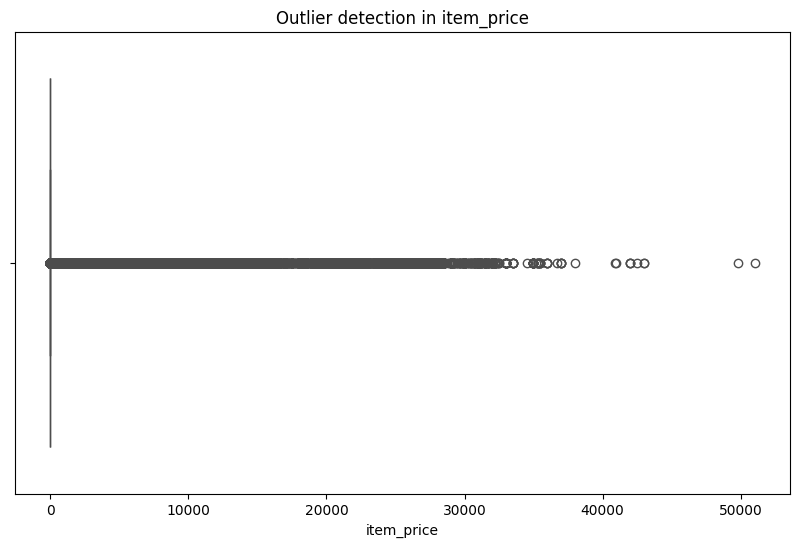

In [57]:
boxplot(df_train, "item_price")

In [58]:
outliers = df_train[df_train.item_price > 33000]
outliers.item_price.describe().map('{:,.2f}'.format)

count        47.00
mean     37,110.08
std       3,931.42
min      33,490.00
25%      34,990.00
50%      35,490.00
75%      36,990.00
max      50,999.00
Name: item_price, dtype: object

In [62]:
check = outliers.sample(n = 3)
outliers_spec(check, 'item_price', df_item_categories, df_items)

Категория: Подарки - Сувениры
Коллекционные шахматы (Властелин Колец)
          date_block_num  item_price
17893893              14     50999.0
Категория: Игровые консоли - PS4
Комплект Sony PlayStation 4 (1Tb) Black (CUH-1208B) + игра Uncharted: Натан Дрейк. Коллекция
          date_block_num  item_price
41640850              33     34990.0
Категория: Игровые консоли - XBOX ONE
Комплект "Microsoft Xbox One 500GB" + "Xbox One Kinect (Сенсор)" + "Dance Central Spotlight" + "Xbox
          date_block_num  item_price
31130319              25     34990.0


Data that looked like outliers correspond to real-world data

Log transformation of 'item_price' to reduce skewness 

In [63]:
df_train['item_price_log'] = np.log1p(df_train['item_price'])

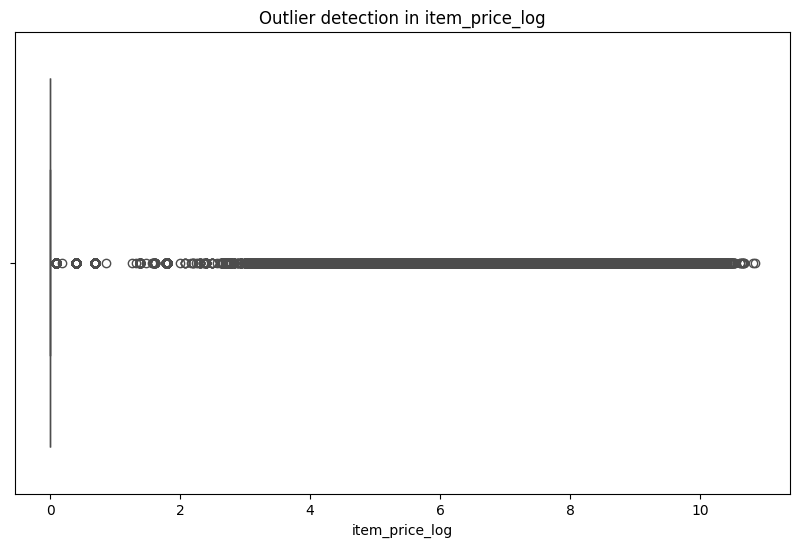

In [64]:
boxplot(df_train, 'item_price_log')

In [65]:
df_train.item_price_log.describe().map(lambda x: f"{x:0.3f}")

count    42474228.000
mean            0.230
std             1.177
min             0.000
25%             0.000
50%             0.000
75%             0.000
max            10.840
Name: item_price_log, dtype: object

Item_cnt_month performance during each time period

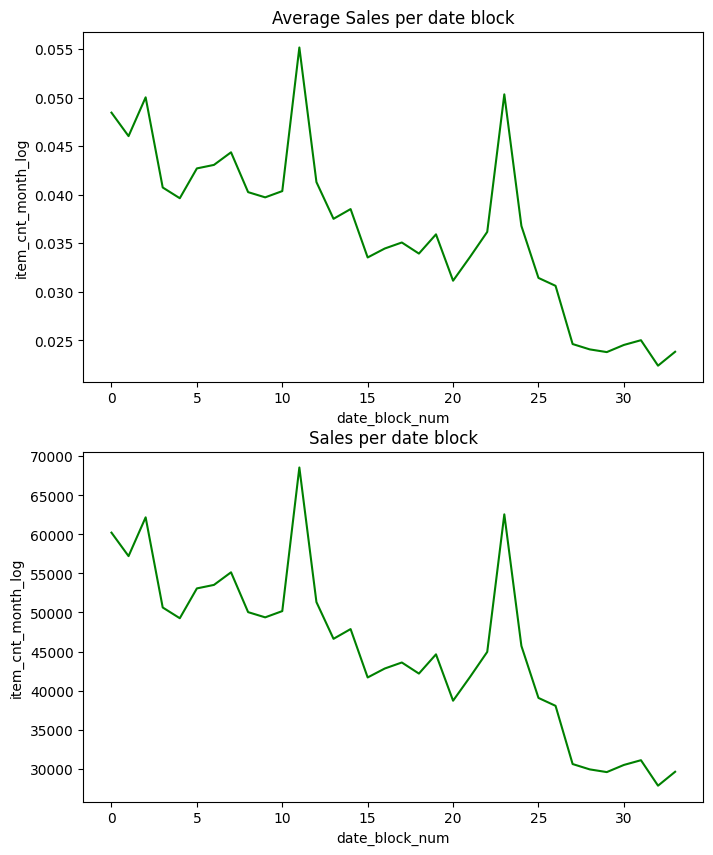

In [24]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.lineplot(data = df_train.loc[df_train['date_block_num'] < 34].groupby('date_block_num').agg({'item_cnt_month_log': 'mean'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g', ax = ax[0]).set_title('Average Sales per date block')

sns.lineplot(data = df_train.loc[df_train['date_block_num'] < 34].groupby('date_block_num').agg({'item_cnt_month_log': 'sum'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g', ax = ax[1]).set_title('Sales per date block')

plt.show()

Time-influenced features engineering

In [6]:
group = df_train.groupby('date_block_num').agg({'item_cnt_month_log':['sum', 'mean']})
group = group.reset_index()
group['date'] = pd.date_range(start='2013-01-01', periods=35, freq='ME')
group['month'] = group['date'].dt.month
group['year'] = group['date'].dt.year
group.head()

date_block_num item_cnt_month_log                 date month  year
                                sum      mean                       
0              0       60214.853279  0.048445 2013-01-31     1  2013
1              1       57211.057757  0.046029 2013-02-28     2  2013
2              2       62174.577721  0.050022 2013-03-31     3  2013
3              3       50636.383487  0.040739 2013-04-30     4  2013
4              4       49261.175075  0.039633 2013-05-31     5  2013

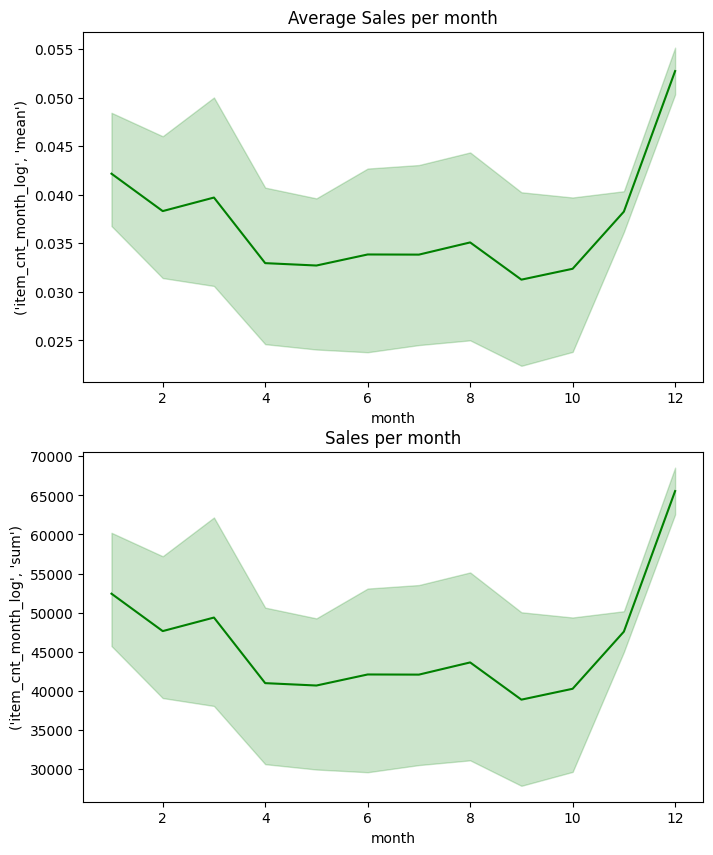

In [26]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'month', y = ('item_cnt_month_log', 'mean'), c = 'g', ax = ax[0]).set_title('Average Sales per month')

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'month', y = ('item_cnt_month_log', 'sum'), c = 'g', ax = ax[1]).set_title('Sales per month')

plt.show()

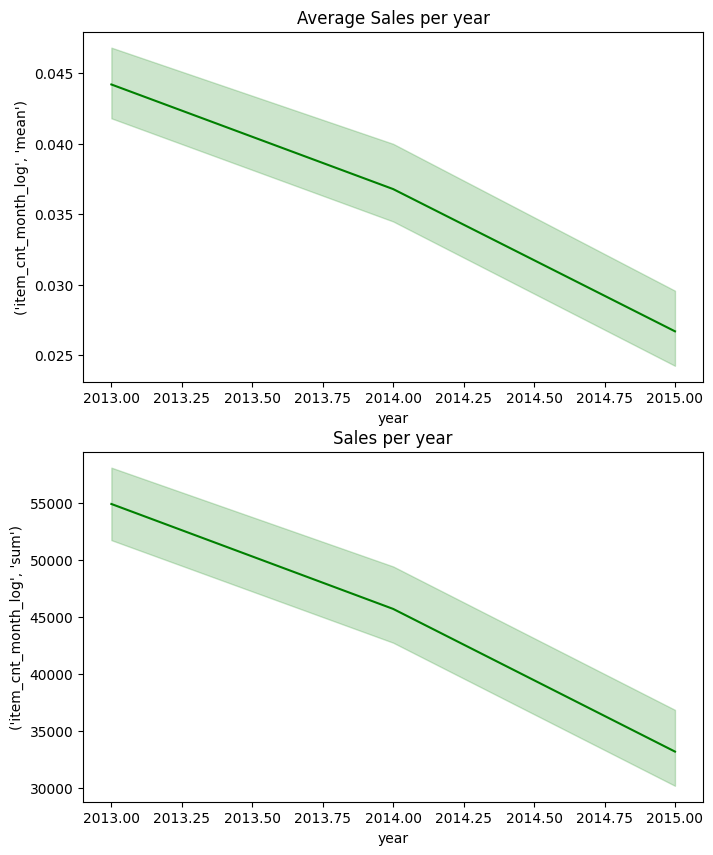

In [27]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'year', y = ('item_cnt_month_log', 'mean'), c = 'g', ax = ax[0]).set_title('Average Sales per year')

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'year', y = ('item_cnt_month_log', 'sum'), c = 'g', ax = ax[1]).set_title('Sales per year')

plt.show()

As we have correlation of new features 'month' and 'year' with our target, it will be reasonable to add them in our df

In [10]:
group = group[['date_block_num', 'month', 'year']]

In [11]:
df_train = pd.merge(df_train, group, on = 'date_block_num', how = 'left')

In [62]:
df_train.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year
0,0,2,0,0.0,0.0,0.0,0.0,1,2013
1,0,2,1,0.0,0.0,0.0,0.0,1,2013


Shop_id - target dependence

In [13]:
encoder = LabelEncoder()

In [14]:
group = df_train.groupby('shop_id').agg({'item_cnt_month_log':['sum', 'mean']}).reset_index()
group['shop_id_encoded'] = encoder.fit_transform(group['shop_id'])
group.head()

shop_id item_cnt_month_log           shop_id_encoded
                         sum      mean                
0       2       14397.701558  0.019287               0
1       3       14675.222961  0.019659               1
2       4       21165.202454  0.028352               2
3       5       21433.211407  0.028711               3
4       6       44110.317940  0.059089               4

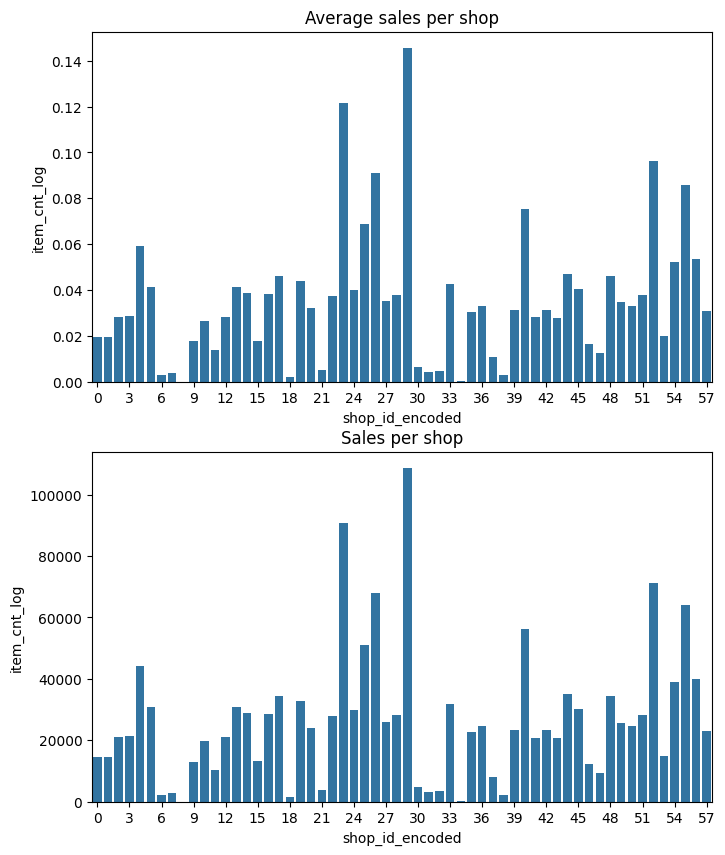

In [65]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

length = len(group) + 1

sns.barplot(x = group['shop_id_encoded'], y = group['item_cnt_month_log', 'mean'], ax = ax[0]).set_title('Average sales per shop')

sns.barplot(x = group['shop_id_encoded'], y = group['item_cnt_month_log', 'sum'], ax = ax[1]).set_title('Sales per shop')

ax[0].set_ylabel('item_cnt_log')
ax[1].set_ylabel('item_cnt_log')

plt.setp(ax, xticks=np.arange(0, length, 3), xticklabels=np.arange(0, length, 3),)
plt.show()

In [15]:
df_train['shop_id_encoded'] = encoder.fit_transform(df_train['shop_id'])

We have for each shop id, but in one city could be several shops(creating new feature)

In [16]:
df_shops['city'] = df_shops['shop_name'].str.split(' ').apply(lambda x: x[0])
df_shops['city_id'] = encoder.fit_transform(df_shops['city'])
df_shops['shop_id_encoded'] = encoder.fit_transform(df_shops['shop_id'])
df_shops.head()

,shop_name,shop_id,city,city_id,shop_id_encoded
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,29,0
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,29,1
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0,2
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1,3
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2,4


In [17]:
group = df_train.groupby('shop_id_encoded').agg({'item_cnt_month_log':'sum'})
group = group.reset_index()
group = pd.merge(group, df_shops, on = 'shop_id_encoded', how = 'left')
group.head()

,shop_id_encoded,item_cnt_month_log,shop_name,shop_id,city,city_id
0,0,14397.701558,"Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,1,14675.222961,"Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,2,21165.202454,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,3,21433.211407,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,4,44110.317940,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


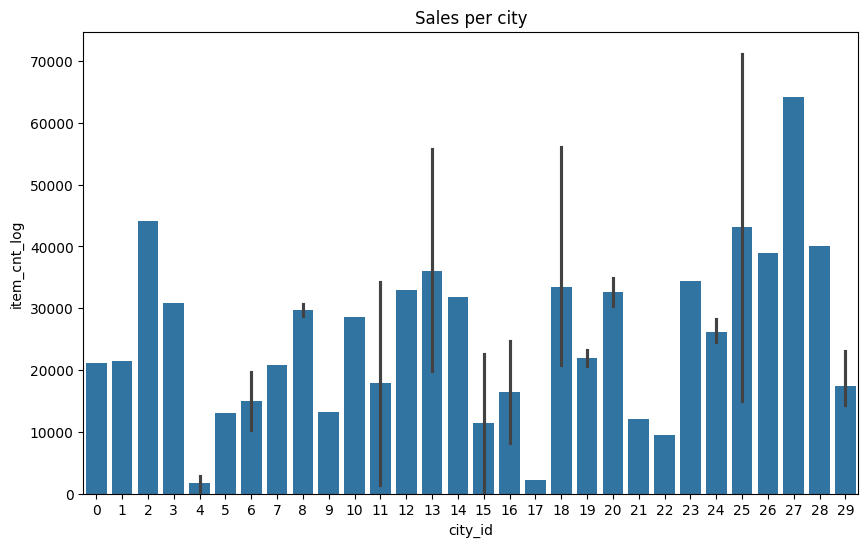

In [69]:
plt.figure(figsize=(10,6))

length = len(group) + 1

sns.barplot(x = group['city_id'], y = group['item_cnt_month_log']).set_title('Sales per city')

plt.ylabel('item_cnt_log')

plt.setp(ax, xticks=np.arange(0, length, 3), xticklabels=np.arange(0, length, 3),)
plt.show()

We also have dependence between city_id and target

In [18]:
group = group[['shop_id_encoded', 'city_id']]
df_train = pd.merge(df_train, group, on = 'shop_id_encoded', how = 'left')
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id
0,0,2,0,0.0,0.0,0.0,0.0,1,2013,0,29
1,0,2,1,0.0,0.0,0.0,0.0,1,2013,0,29
2,0,2,2,0.0,0.0,0.0,0.0,1,2013,0,29
3,0,2,3,0.0,0.0,0.0,0.0,1,2013,0,29
4,0,2,4,0.0,0.0,0.0,0.0,1,2013,0,29


Item-price dependence

In [19]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month_log': 'sum', 'item_price_log': 'mean'}).reset_index()
group.head()

,date_block_num,shop_id,item_id,item_cnt_month_log,item_price_log
0,0,2,0,0.0,0.0
1,0,2,1,0.0,0.0
2,0,2,2,0.0,0.0
3,0,2,3,0.0,0.0
4,0,2,4,0.0,0.0


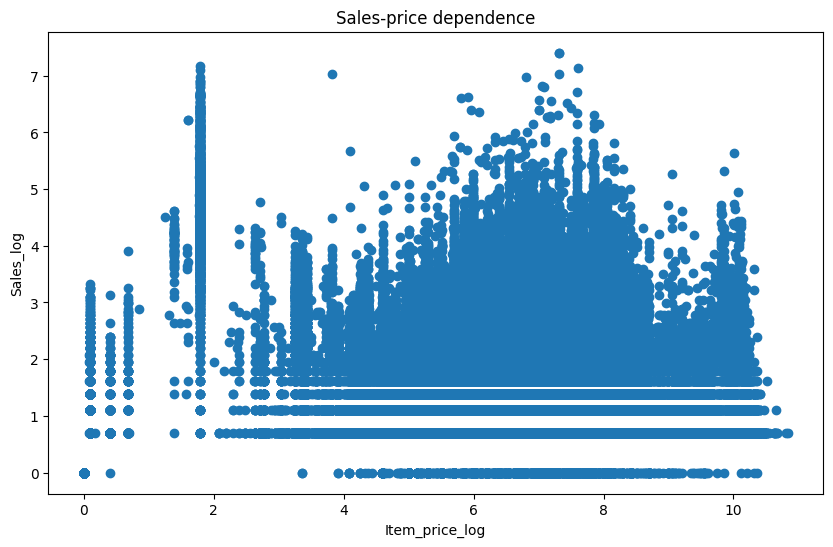

In [72]:
plt.figure(figsize=(10,6))
plt.scatter(x = group['item_price_log'],
            y = group['item_cnt_month_log'])

plt.xlabel('Item_price_log')
plt.ylabel('Sales_log')
plt.title('Sales-price dependence')

plt.show()

We do not have strong correlation between item price and Sales

As our need to predict Item_cnt_per_month, it will be reasonable to creature feature that will illustrate month dinamics on item_price base

In [73]:
group = df_train[['item_price', 'item_cnt_month', 'date_block_num', 'shop_id', 'item_cnt_month_log']]
group['revenue'] = (group.item_price * group.item_cnt_month)
group.head()

C:\Users\User\AppData\Local\Temp\ipykernel_127620\3358020166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['revenue'] = (group.item_price * group.item_cnt_month)


,item_price,item_cnt_month,date_block_num,shop_id,item_cnt_month_log,revenue
0,0.0,0.0,0,2,0.0,0.0
1,0.0,0.0,0,2,0.0,0.0
2,0.0,0.0,0,2,0.0,0.0
3,0.0,0.0,0,2,0.0,0.0
4,0.0,0.0,0,2,0.0,0.0


<Figure size 1000x600 with 0 Axes>

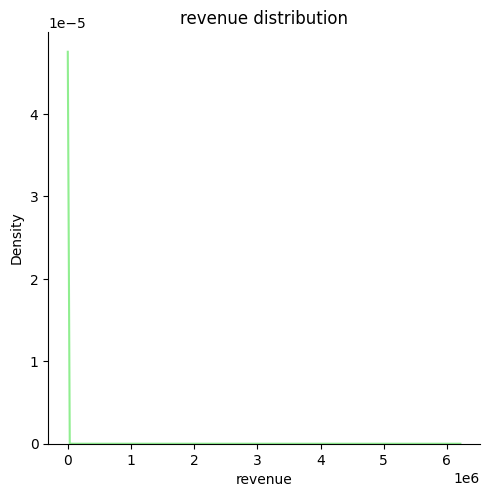

In [45]:
distribution_plot(group, 'revenue')

In [74]:
group['revenue_log'] = np.log1p(group['revenue'])

C:\Users\User\AppData\Local\Temp\ipykernel_127620\650943199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['revenue_log'] = np.log1p(group['revenue'])


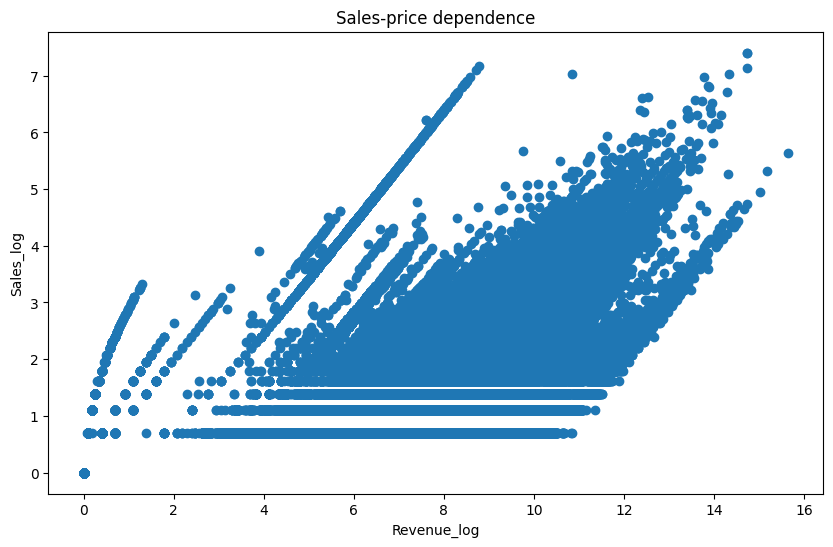

In [47]:
plt.figure(figsize=(10,6))
plt.scatter(x = group['revenue_log'],
            y = group['item_cnt_month_log'])

plt.xlabel('Revenue_log')
plt.ylabel('Sales_log')
plt.title('Sales-price dependence')

plt.show()

In [20]:
df_train['revenue_log'] = np.log1p((df_train.item_price * df_train.item_cnt_month))
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log
0,0,2,0,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
1,0,2,1,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
2,0,2,2,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
3,0,2,3,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
4,0,2,4,0.0,0.0,0.0,0.0,1,2013,0,29,0.0


In [21]:
df_items = df_items[['item_id', 'item_category_id']]
df_train = pd.merge(df_train, df_items, on = 'item_id', how = 'left')
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log,item_category_id
0,0,2,0,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40
1,0,2,1,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,76
2,0,2,2,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40
3,0,2,3,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40
4,0,2,4,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40


Item-category_id dependence

In [50]:
df_item_categories.item_category_name.unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

categories names we could split inro 2 parts: main category (for most cases ferst word is not a unique one) and minor category

In [22]:
df_item_categories['main_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[0])
df_item_categories['main_category_id'] = encoder.fit_transform(df_item_categories['main_category'])
df_item_categories.head()

,item_category_name,item_category_id,main_category,main_category_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


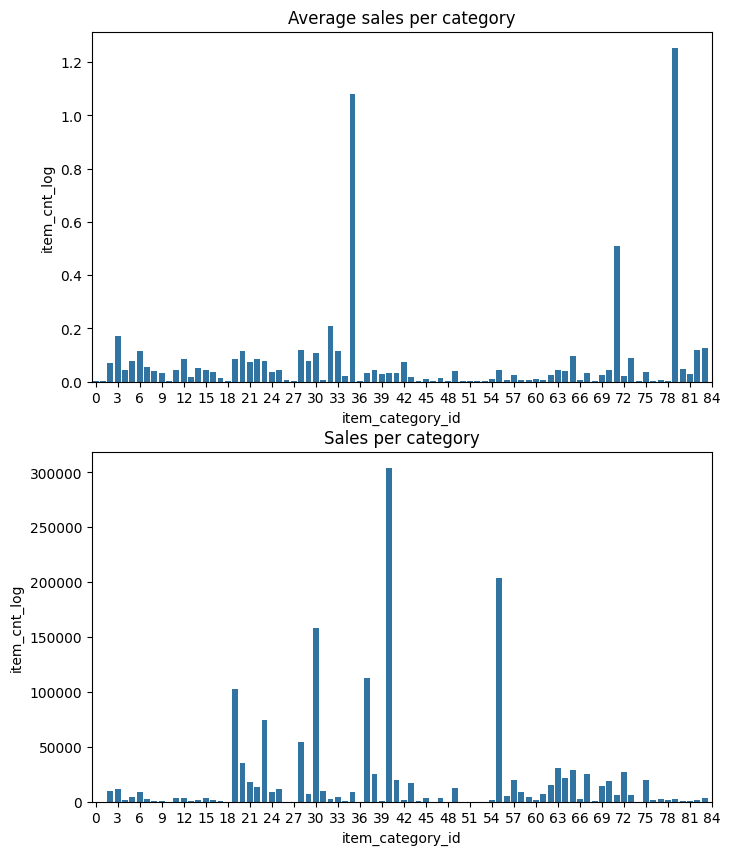

In [52]:
group = df_train.groupby('item_category_id').agg({'item_cnt_month_log':['sum', 'mean']}).reset_index()

figure, ax = plt.subplots(2, 1, figsize = (8,10))

length = len(group) + 1

sns.barplot(x = group['item_category_id'], y = group['item_cnt_month_log', 'mean'], ax = ax[0]).set_title('Average sales per category')

sns.barplot(x = group['item_category_id'], y = group['item_cnt_month_log', 'sum'], ax = ax[1]).set_title('Sales per category')

ax[0].set_ylabel('item_cnt_log')

ax[1].set_ylabel('item_cnt_log')


plt.setp(ax, xticks=np.arange(0, length, 3), xticklabels=np.arange(0, length, 3),)
plt.show()

In [53]:
df_items.loc[df_items.item_category_id == 40]['item_id'].nunique()

5035

In [23]:
df_item_categories['minor_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[1] if len(x) > 1 else x[0])
df_item_categories['minor_category_id'] = encoder.fit_transform(df_item_categories['minor_category'])
df_item_categories.head()

,item_category_name,item_category_id,main_category,main_category_id,minor_category,minor_category_id
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники,31
1,Аксессуары - PS2,1,Аксессуары,1,PS2,11
2,Аксессуары - PS3,2,Аксессуары,1,PS3,12
3,Аксессуары - PS4,3,Аксессуары,1,PS4,13
4,Аксессуары - PSP,4,Аксессуары,1,PSP,15


In [24]:
category_set = df_item_categories[['item_category_id', 'main_category_id', 'minor_category_id']]
df_train = pd.merge(category_set, df_train, on = 'item_category_id', how = 'left')
df_train.head()

,item_category_id,main_category_id,minor_category_id,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log
0,0,0,31,0,2,16255,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
1,0,0,31,0,2,16256,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
2,0,0,31,0,2,16257,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
3,0,0,31,0,3,16255,0.0,0.0,0.0,0.0,1,2013,1,29,0.0
4,0,0,31,0,3,16256,0.0,0.0,0.0,0.0,1,2013,1,29,0.0


In [56]:
group1 = df_train.groupby('main_category_id').agg({'item_cnt_month_log': 'sum'}).reset_index()
group2 = df_train.groupby('minor_category_id').agg({'item_cnt_month_log': 'sum'}).reset_index()

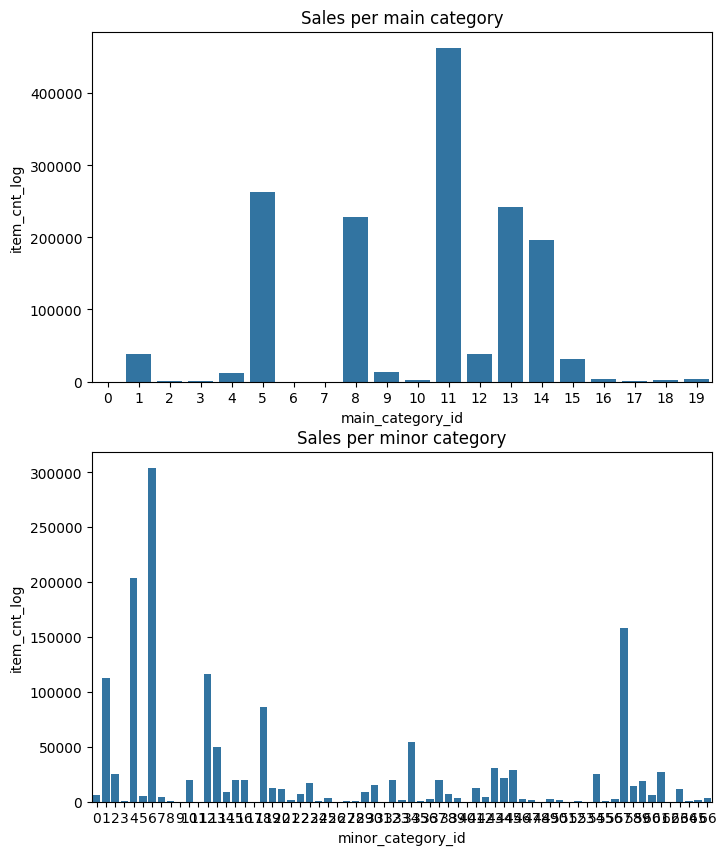

In [59]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.barplot(x = group1['main_category_id'], y = group1['item_cnt_month_log'], ax = ax[0]).set_title('Sales per main category')

sns.barplot(x = group2['minor_category_id'], y = group2['item_cnt_month_log'], ax = ax[1]).set_title('Sales per minor category')

ax[0].set_ylabel('item_cnt_log')

ax[1].set_ylabel('item_cnt_log')

plt.show()

Correlation

In [67]:
df_train.columns

Index(['item_category_id', 'main_category_id', 'minor_category_id',
       'date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'item_cnt_month_log', 'item_price_log', 'month', 'year',
       'shop_id_encoded', 'city_id', 'revenue_log'],
      dtype='object')

In [25]:
categorical = ['date_block_num', 'shop_id_encoded', 'item_id', 'item_category_id',
              'main_category_id', 'minor_category_id', 'city_id', 'month', 'year']

numerical = ['revenue_log', 'item_price_log']

target = ['item_cnt_month']

In [66]:
columns, correlations = [], []

for col in numerical:
    columns.append(col)
    correlations.append(stats.spearmanr(df_train[col], df_train['item_cnt_month_log'])[0])

num_corr = pd.DataFrame({'column': columns, 'correlation': correlations})

num_corr.style.background_gradient()

,column,correlation
0,revenue_log,0.999810
1,item_price_log,0.998795


In [69]:
for category in categorical:
    correlation_ratio(df_train['item_cnt_month_log'], df_train[category], category)

Correlation between sales and date_block_num
Eta_squared: 0.0015
Eta: 0.0389
Correlation between sales and shop_id_encoded
Eta_squared: 0.0007
Eta: 0.0269
Correlation between sales and item_id
Eta_squared: 0.0006
Eta: 0.0253
Correlation between sales and item_category_id
Eta_squared: 0.0042
Eta: 0.0644
Correlation between sales and main_category_id
Eta_squared: 0.0054
Eta: 0.0736
Correlation between sales and minor_category_id
Eta_squared: 0.0019
Eta: 0.0432
Correlation between sales and city_id
Eta_squared: 0.0004
Eta: 0.0202
Correlation between sales and month
Eta_squared: 0.0001
Eta: 0.0081
Correlation between sales and year
Eta_squared: 0.0015
Eta: 0.0384


In [26]:
data = df_train[['item_category_id', 'main_category_id', 'minor_category_id',
       'date_block_num', 'item_id','item_cnt_month_log', 'item_price_log', 'month', 'year',
       'shop_id_encoded', 'city_id', 'revenue_log']]

In [27]:
to_csv(data, 'data.csv')

In [3]:
data = load('data.csv')

Adding more time-dependent features

In [ ]:
group = data.sort_values(by=['date_block_num', 'shop_id_encoded', 'item_id'])
for lag in [1, 2, 3, 6, 12]:
    data[f'item_cnt_month_lag_{lag}'] = (
        group
        .groupby(['date_block_num', 'shop_id_encoded', 'item_id'])['item_cnt_month_log']
        .shift(lag)
    )

In [19]:
data = data.fillna(0)

In [20]:
data.head(2)

,item_category_id,main_category_id,minor_category_id,date_block_num,item_id,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log,item_cnt_month_log_1,item_cnt_month_log_2,item_cnt_month_log_3,item_cnt_month_log_6,item_cnt_month_log_12
0,0,0,31,0,16255,0.0,0.0,1,2013,0,29,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,31,0,16256,0.0,0.0,1,2013,0,29,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
to_csv(data, 'data.csv')